In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [2]:
df = pd.read_csv('df_total_sp.csv')
df = df.drop(columns = ['SG_UF'])

In [3]:
df

,NU_IDADE_N,CRITERIO,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,CHIK
0,37.0,EpiClinico,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,63.0,Laboratorial,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,72.0,EpiClinico,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,21.0,EpiClinico,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0
4,72.0,Laboratorial,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761395,22.0,Laboratorial,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1
1761396,21.0,Laboratorial,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1761397,54.0,Laboratorial,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1
1761398,67.0,Laboratorial,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1


In [4]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico'] 
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO'])
df_epi = df_epi.drop(columns = ['CRITERIO'])

### Train-test split

In [5]:
X = df_lab.iloc[:,0:14]
y = df_lab.iloc[:,15]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [6]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (342966,) 2368 340598
Test:  (257225,) 1776 255449
Validation:  (257225,) 1776 255449


### Logistic regression

In [7]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict_proba(X_train)[:,1]
fpr_1, tpr_1, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.7707924614267465


### Random Forest

In [17]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_2, tpr_2, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.9654128659025472


<BarContainer object of 14 artists>

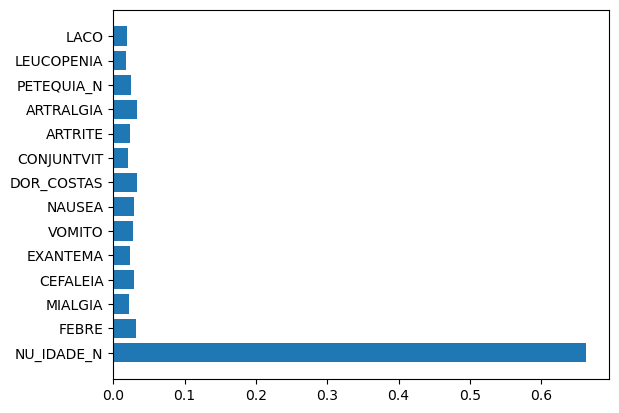

In [18]:
plt.barh(X_train.columns, rfc.feature_importances_)

### XGBoost

In [19]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train, y_train)
y_pred_train = clx.predict_proba(X_train)[:,1]
fpr_3, tpr_3, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8527098777073409


<BarContainer object of 14 artists>

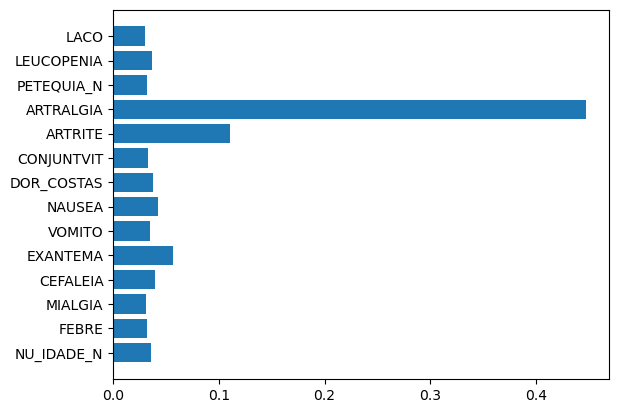

In [20]:
plt.barh(X_train.columns, clx.feature_importances_)

### Random forest with class weights 

In [21]:
rfc = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_4, tpr_4, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.9571416945343191


<BarContainer object of 14 artists>

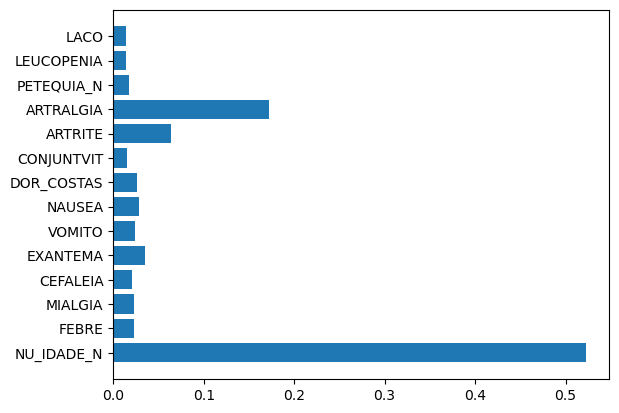

In [22]:
plt.barh(X_train.columns, rfc.feature_importances_)

### Training with subsampling

In [23]:
num_train_chik = sum(y_train == 1)
ind_train_chik = (y_train == 1)

In [24]:
X_train_chik = X_train.loc[ind_train_chik]
y_train_chik = y_train.loc[ind_train_chik]
X_train_chik = X_train_chik.reset_index(drop = True)
y_train_chik = y_train_chik.reset_index(drop = True)

In [25]:
ind_train_denv = (y_train == 0)

In [26]:
X_train_denv = X_train.loc[ind_train_denv]
y_train_denv = y_train.loc[ind_train_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.reset_index(drop = True)

In [27]:
indexes_denv = np.random.randint(0,X_train_denv.shape[0],num_train_chik)
X_train_denv = X_train_denv.loc[indexes_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.loc[indexes_denv]
y_train_denv = y_train_denv.reset_index(drop = True)

In [28]:
X_train_2 = pd.concat([X_train_denv, X_train_chik])
y_train_2 = pd.concat([y_train_denv, y_train_chik])

In [29]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train_2, y_train_2)
y_pred_train = logreg.predict_proba(X_train_2)[:,1]
fpr_5, tpr_5, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.773652661186313


In [30]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_2 ,y_train_2)
y_pred_train = rfc.predict_proba(X_train_2)[:,1]
fpr_6, tpr_6, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9769329909776753


<BarContainer object of 14 artists>

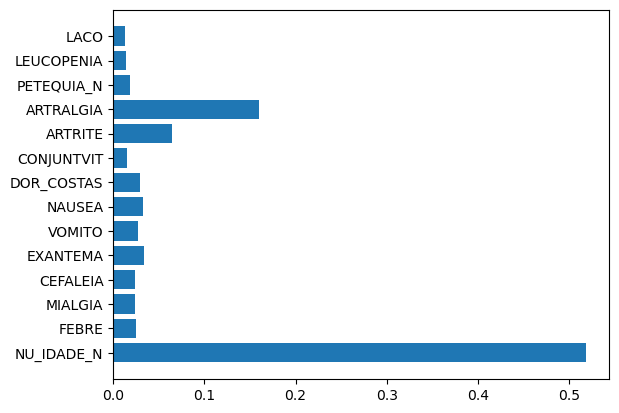

In [31]:
plt.barh(X_train.columns, rfc.feature_importances_)

In [32]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train_2, y_train_2)
y_pred_train = clx.predict_proba(X_train_2)[:,1]
fpr_7, tpr_7, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9013813651330806


<BarContainer object of 14 artists>

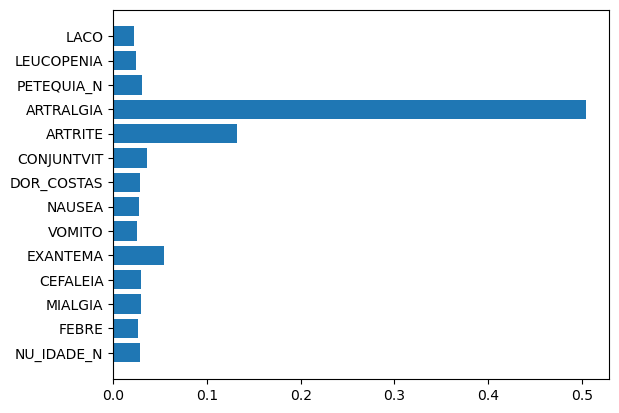

In [33]:
plt.barh(X_train.columns, clx.feature_importances_)

### KNN classifier

In [34]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_pred_train = knn.predict_proba(X_train)[:,1]
fpr_8, tpr_8, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.7682502750428776


In [35]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_2, y_train_2)
y_pred_train = knn.predict_proba(X_train_2)[:,1]
fpr_9, tpr_9, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.84730029332542


### Plotting all classifiers

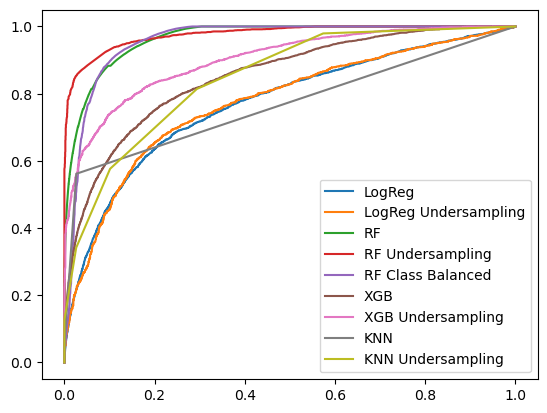

In [36]:
plt.plot(fpr_1, tpr_1, label = 'LogReg')
plt.plot(fpr_5, tpr_5, label = 'LogReg Undersampling')
plt.plot(fpr_2, tpr_2, label = 'RF')
plt.plot(fpr_6, tpr_6, label = 'RF Undersampling')
plt.plot(fpr_4, tpr_4, label = 'RF Class Balanced')
plt.plot(fpr_3, tpr_3, label = 'XGB')
plt.plot(fpr_7, tpr_7, label = 'XGB Undersampling')
plt.plot(fpr_8, tpr_8, label = 'KNN')
plt.plot(fpr_9, tpr_9, label = 'KNN Undersampling')
plt.legend()
plt.show()